# Lab Four: GAN Example Fixing

#### CS8321: Neural Networks and Machine Learning
    
Johnathan Barr - 39854013
<br>
Will Lacey - 45906124

## Import Modules and Initialization

Before we begin, let's import essential packages for data analysis.

In [ ]:
import keras
import keras.backend as K
from keras import layers
from keras.preprocessing import image

import numpy as np

import matplotlib.pyplot as plt

import os

import tensorflow as tf

## Francois Chollet's Notebook

<em>In this lab you will improve upon the methods employed by Chollet in his example from the book: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.5-introduction-to-gans.ipynb</em>

<em>[<strong>15 points</strong>] Run the code from fchollet "as-is" to generate samples of frogs from CIFAR. Are the results subjectively satisfying? Explain. If you wish, you can also change this code to use PyTorch if you prefer to use a different implementation. </em>

The following cells have been copied almost verbatim and have only been modified so that they work in our environment. Additionally, we have left Chollet's writing in the notebook as it serves as a fantastic description of the GAN architecture and implementation.

### A schematic GAN implementation

<em>In what follows, we explain how to implement a GAN in Keras, in its barest form -- since GANs are quite advanced, diving deeply into the technical details would be out of scope for us. Our specific implementation will be a deep convolutional GAN, or DCGAN: a GAN where the generator and discriminator are deep convnets. In particular, it leverages a `Conv2DTranspose` layer for image upsampling in the generator.</em>

<em>We will train our GAN on images from CIFAR10, a dataset of 50,000 32x32 RGB images belong to 10 classes (5,000 images per class). To make things even easier, we will only use images belonging to the class "frog".</em>

<em>Schematically, our GAN looks like this:</em>

* <em>A `generator` network maps vectors of shape `(latent_dim,)` to images of shape `(32, 32, 3)`.</em>
* <em>A `discriminator` network maps images of shape (32, 32, 3) to a binary score estimating the probability that the image is real.</em>
* <em>A `gan` network chains the generator and the discriminator together: `gan(x) = discriminator(generator(x))`. Thus this `gan` network maps latent space vectors to the discriminator's assessment of the realism of these latent vectors as decoded by the generator.</em>
* <em>We train the discriminator using examples of real and fake images along with "real"/"fake" labels, as we would train any regular image classification model.</em>
* <em>To train the generator, we use the gradients of the generator's weights with regard to the loss of the `gan` model. This means that, at every step, we move the weights of the generator in a direction that will make the discriminator more likely to classify as "real" the images decoded by the generator. I.e. we train the generator to fool the discriminator.</em>

### A bag of tricks

<em>Training GANs and tuning GAN implementations is notoriously difficult. There are a number of known "tricks" that one should keep in mind. Like most things in deep learning, it is more alchemy than science: these tricks are really just heuristics, not theory-backed guidelines. They are backed by some level of intuitive understanding of the phenomenon at hand, and they are known to work well empirically, albeit not 
necessarily in every context.</em>

<em>Here are a few of the tricks that we leverage in our own implementation of a GAN generator and discriminator below. It is not an exhaustive list of GAN-related tricks; you will find many more across the GAN literature.</em>

* <em>We use `tanh` as the last activation in the generator, instead of `sigmoid`, which would be more commonly found in other types of models.</em>
* <em>We sample points from the latent space using a _normal distribution_ (Gaussian distribution), not a uniform distribution.</em>
* <em>Stochasticity is good to induce robustness. Since GAN training results in a dynamic equilibrium, GANs are likely to get "stuck" in all sorts of ways. Introducing randomness during training helps prevent this. We introduce randomness in two ways: 1) we use dropout in the discriminator 2) we add some random noise to the labels for the discriminator.</em>
* <em>Sparse gradients can hinder GAN training. In deep learning, sparsity is often a desirable property, but not in GANs. There are two things that can induce gradient sparsity: 1) max pooling operations, 2) ReLU activations. Instead of max pooling, we recommend using strided convolutions for downsampling, and we recommend using a `LeakyReLU` layer instead of a ReLU activation. It is similar to ReLU but it relaxes sparsity constraints by allowing small negative activation values.</em>
* <em>In generated images, it is common to see "checkerboard artifacts" caused by unequal coverage of the pixel space in the generator. To fix this, we use a kernel size that is divisible by the stride size, whenever we use a strided `Conv2DTranpose` or `Conv2D` in both the 
generator and discriminator.</em>

### The generator

<em>First, we develop a `generator` model, which turns a vector (from the latent space -- during training it will sampled at random) into a candidate image. One of the many issues that commonly arise with GANs is that the generator gets stuck with generated images that look like noise. A possible solution is to use dropout on both the discriminator and generator.</em>

In [1]:
latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# First, transform the input into a 16x16 128-channels feature map
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

# Then, add a convolution layer
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Upsample to 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

# Few more conv layers
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# Produce a 32x32 1-channel feature map
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

### The discriminator

<em>Then, we develop a `discriminator` model, that takes as input a candidate image (real or synthetic) and classifies it into one of two classes, either "generated image" or "real image that comes from the training set".</em>

In [2]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# One dropout layer - important trick!
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# To stabilize training, we use learning rate decay
# and gradient clipping (by value) in the optimizer.
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 6, 6, 128)         0         
__________

### The adversarial network

<em>Finally, we setup the GAN, which chains the generator and the discriminator. This is the model that, when trained, will move the generator in a direction that improves its ability to fool the discriminator. This model turns latent space points into a classification decision, "fake" or "real", and it is meant to be trained with labels that are always "these are real images". So training `gan` will updates the weights of `generator` in a way that makes `discriminator` more likely to predict "real" when looking at fake images. Very importantly, we set the discriminator to be frozen during training (non-trainable): its weights will not be updated when training `gan`. If the discriminator weights could be updated during this process, then we would be training the discriminator to always predict "real", which is not what we want!</em>

In [3]:
# Set discriminator weights to non-trainable
# (will only apply to the `gan` model)
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## How to train your DCGAN

<em>Now we can start training. To recapitulate, this is schematically what the training loop looks like:</em>

```
for each epoch:
    * Draw random points in the latent space (random noise).
    * Generate images with `generator` using this random noise.
    * Mix the generated images with real ones.
    * Train `discriminator` using these mixed images, with corresponding targets, either "real" (for the real images) or "fake" (for the generated images).
    * Draw new random points in the latent space.
    * Train `gan` using these random vectors, with targets that all say "these are real images". This will update the weights of the generator (only, since discriminator is frozen inside `gan`) to move them towards getting the discriminator to predict "these are real images" for generated images, i.e. this trains the generator to fool the discriminator.
```

<em>Let's implement it:</em> 

The following cells have been slightly altered. First, let's load and prepare the data.

In [ ]:
# Load CIFAR10 data
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# Select frog images (class 6)
x_train = x_train[y_train.flatten() == 6]

# Normalize data
x_train = x_train.reshape(
    (x_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

Next, let's prepare a reusable training function for our model and models below.

In [ ]:
def train(gan, discriminator, iterations = 10000, batch_size = 20, name = 'gan', save_dir = 'data/'):
    # Start training loop
    start = 0
    for step in range(iterations):
        # Sample random points in the latent space
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # Decode them to fake images
        generated_images = generator.predict(random_latent_vectors)

        # Combine them with real images
        stop = start + batch_size
        real_images = x_train[start: stop]
        combined_images = np.concatenate([generated_images, real_images])

        # Assemble labels discriminating real from fake images
        labels = np.concatenate([np.ones((batch_size, 1)),
                                 np.zeros((batch_size, 1))])

        # Add random noise to the labels - important trick!
        labels += 0.05 * np.random.random(labels.shape)

        # Train the discriminator
        d_loss = discriminator.train_on_batch(combined_images, labels)

        # sample random points in the latent space
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # Assemble labels that say "all real images"
        misleading_targets = np.zeros((batch_size, 1))

        # Train the generator (via the gan model, where the discriminator weights are frozen)
        a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

        start += batch_size
        if start > len(x_train) - batch_size:
          start = 0

        # Occasionally save / plot
        if step % 100 == 0:
            # Save model weights
            gan.save_weights(f'{name}.h5')

            # Print metrics
            print('discriminator loss at step %s: %s' % (step, d_loss))
            print('adversarial loss at step %s: %s' % (step, a_loss))

            # Save one generated image
            img = image.array_to_img(generated_images[0] * 255., scale=False)
            img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

            # Save one real image, for comparison
            img = image.array_to_img(real_images[0] * 255., scale=False)
            img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

Now that we have accomplished that, let's train for 10,000 iterations.

In [4]:
train(gan, discriminator, iterations = 10000, save_dir = 'data/base/')

discriminator loss at step 0: 0.685675
adversarial loss at step 0: 0.667591
discriminator loss at step 100: 0.756201
adversarial loss at step 100: 0.820905
discriminator loss at step 200: 0.699047
adversarial loss at step 200: 0.776581
discriminator loss at step 300: 0.684602
adversarial loss at step 300: 0.513813
discriminator loss at step 400: 0.707092
adversarial loss at step 400: 0.716778
discriminator loss at step 500: 0.686278
adversarial loss at step 500: 0.741214
discriminator loss at step 600: 0.692786
adversarial loss at step 600: 0.745891
discriminator loss at step 700: 0.69771
adversarial loss at step 700: 0.781026
discriminator loss at step 800: 0.69236
adversarial loss at step 800: 0.748769
discriminator loss at step 900: 0.663193
adversarial loss at step 900: 0.689923
discriminator loss at step 1000: 0.706922
adversarial loss at step 1000: 0.741314
discriminator loss at step 1100: 0.682189
adversarial loss at step 1100: 0.76548
discriminator loss at step 1200: 0.687244
a

Okay, done. Now back to Chollet's example.

<em>Let's display a few of our fake images:</em>

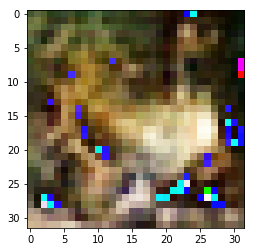

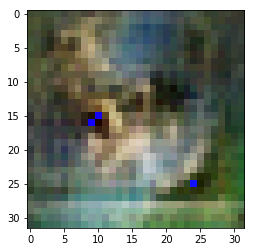

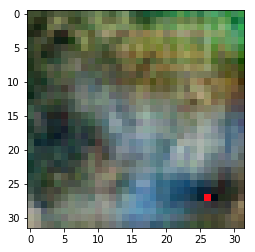

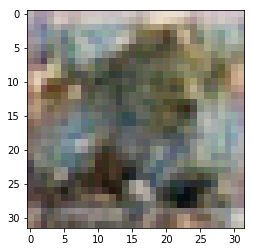

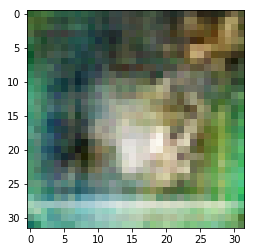

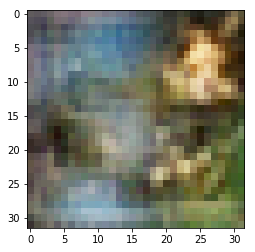

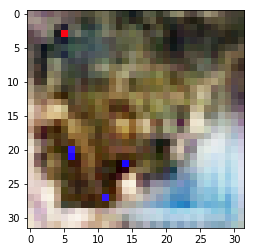

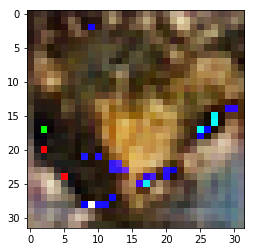

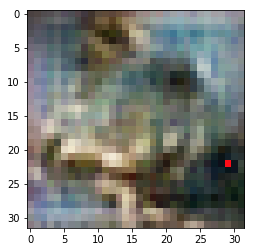

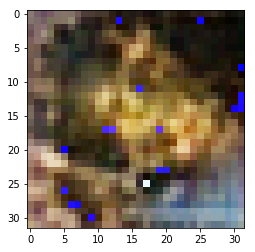

In [5]:
import matplotlib.pyplot as plt

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

<em>Froggy with some pixellated artifacts.</em>

<em>For the remainder of this rubric, you will be adding functionality in the GAN training. You can choose to implement each functionality separately OR to implement each of these progressively, building from each step. In each implementation, try to use the same architecture for the generator and discriminator.</em> 

<em>The list of possible GAN training items to implement are as follows:</em>
* <em>Feature Matching</em>
* <em>Historical Averaging</em>
* <em>Experience Replay</em>
* <em>Least Squares Loss (LSGAN)</em>
* <em>Wasserstein Distance (WGAN)</em>
* <em>Wasserstein Distance with Gradient Penalty (WGAN-GP)</em>
* <em>Another type of GAN architecture or GAN loss function, or a method from the Salimans paper</em>


## LSGAN

<em>[<strong>15 points</strong>] Implement one item from the list in the GAN training and generate samples of CIFAR images (only frogs if you like). Subjectively, did this improve the generated results? Did training time increase or decrease and by how much? Explain.</em>

In [100]:
# create the discriminator with the same input and architecture as Chollet's
ls_discriminator = keras.models.Model(discriminator_input, x)

# compile the discriminator using MSE
ls_discriminator.compile(optimizer=discriminator_optimizer, loss='mse')

# set trainable to false
ls_discriminator.trainable = False

Next, let's create the combined architecture of the generator and discriminator models.

In [101]:
# create the GAN using the same input and architecture as Chollet's
ls_gan = keras.models.Model(gan_input, gan_output)

# compile the GAN using MSE
ls_gan.compile(optimizer=gan_optimizer, loss='mse')

Again, we are going to train for 10,000 iterations. Let's give it a go.

In [102]:
%%time
train(ls_gan, ls_discriminator, iterations = 10000, name = 'lsgan', save_dir = 'data/lsgan/')

discriminator loss at step 0: 0.25825462
adversarial loss at step 0: 0.25742215


/Users/Johnathan/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


discriminator loss at step 100: 0.52667046
adversarial loss at step 100: 9.0232075e-31
discriminator loss at step 200: 0.31721616
adversarial loss at step 200: 0.81283474
discriminator loss at step 300: 0.29460487
adversarial loss at step 300: 0.3153803
discriminator loss at step 400: 0.24916163
adversarial loss at step 400: 0.29295558
discriminator loss at step 500: 0.26708898
adversarial loss at step 500: 0.28987542
discriminator loss at step 600: 0.26053503
adversarial loss at step 600: 0.30126157
discriminator loss at step 700: 0.25033242
adversarial loss at step 700: 0.27292675
discriminator loss at step 800: 0.25350255
adversarial loss at step 800: 0.28368217
discriminator loss at step 900: 0.25185308
adversarial loss at step 900: 0.28956887
discriminator loss at step 1000: 0.2497302
adversarial loss at step 1000: 0.28124443
discriminator loss at step 1100: 0.27416888
adversarial loss at step 1100: 0.29744104
discriminator loss at step 1200: 0.26016146
adversarial loss at step 12

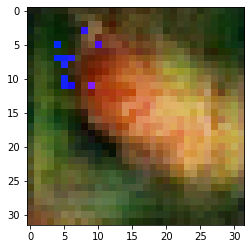

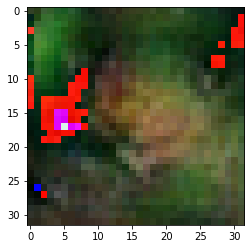

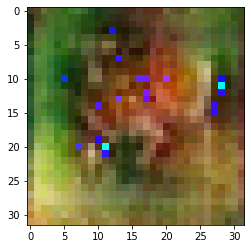

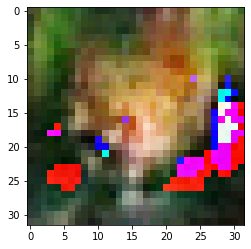

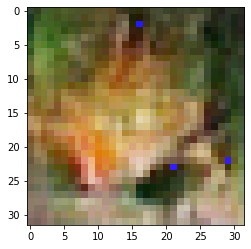

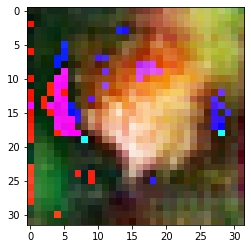

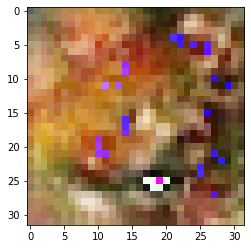

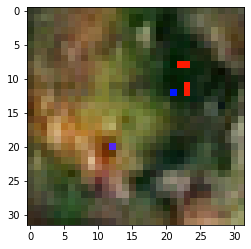

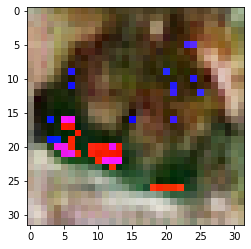

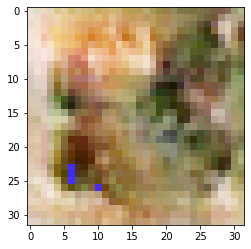

In [103]:
# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()

As you can see, the results are arguably good! It's hard to say if it's "better" than the original Chollet code since it's comparing pixel vomit to pixel vomit, but the colors and shapes fit those of frogs better than Chollet's in our subjective opinion. It's definitely unfortunate that none of these images are exactly frogs... but seeing the progress our model had, we think that if we trained our LSGAN for a longer period, we could have accomplished better results.

## WGAN

<em>[<strong>15 points</strong>] Implement ANOTHER item in the list in the GAN training and generate samples of CIFAR images (only frogs if you like).  Subjectively, did this improve the generated results? Did training time increase or decrease and by how much? Explain.</em>

This implementation of the WGAN has been inspired by following the examples provided by the corresponding GitHub repositories:

https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan/wgan.py & https://github.com/keras-team/keras-contrib/blob/master/examples/improved_wgan.py

These examples provided a significant amount of logic and help in building the following model.

Before building the WGAN, we are first going to create a WGAN Base class that serves as the middle ground between the WGAN model and the WGAN-GP model. 

In [4]:
class WGAN_Base():
    def __init__(self, img_height=32, img_width=32, img_channels=3):
        """
        Initializer for the WGAN_Base Class
        """
        self.img_height = img_height
        self.img_width = img_width
        self.img_channels = img_channels
        self.img_shape = (self.img_height, self.img_width, self.img_channels)
        self.latent_dim = 100
        self.sample_interval = 10
        self.data = None
        
        # initialize the generator and discriminator
        self.generator = self.build_generator()
        self.discriminator = self.build_discriminator()
        
        # model variables
        self.generator_model = None
        self.discriminator_model = None
    
    
    def build_generator(self):
        """
        Creates a generator model that takes a 100-dimensional noise vector as a "seed",
        and outputs images of size img_height x img_width x img_channels.
        """
        model = Sequential()
        model.add(Dense(1024, input_dim=100))
        model.add(LeakyReLU())
        model.add(Dense(128 * 8 * 8))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        if K.image_data_format() == 'channels_first':
            model.add(Reshape((128, 8, 8), input_shape=(128 * 8 * 8,)))
            bn_axis = 1
        else:
            model.add(Reshape((8, 8, 128), input_shape=(128 * 8 * 8,)))
            bn_axis = -1
        model.add(Conv2DTranspose(128, (5, 5), strides=2, padding='same'))
        model.add(BatchNormalization(axis=bn_axis))
        model.add(LeakyReLU())
        model.add(Convolution2D(64, (5, 5), padding='same'))
        model.add(BatchNormalization(axis=bn_axis))
        model.add(LeakyReLU())
        model.add(Conv2DTranspose(64, (5, 5), strides=2, padding='same'))
        model.add(BatchNormalization(axis=bn_axis))
        model.add(LeakyReLU())
        # Because we normalized training inputs to lie in the range [-1, 1],
        # the tanh function should be used for the output of the generator to ensure
        # its output also lies in this range.
        model.add(Convolution2D(3, (5, 5), padding='same', activation='tanh'))
        return model
    
    
    def build_discriminator(self):
        """
        Creates a discriminator model that takes an image as input and outputs a single
        value, representing whether the input is real or generated. Unlike normal GANs, the
        output is not sigmoid and does not represent a probability! Instead, the output
        should be as large and negative as possible for generated inputs and as large and
        positive as possible for real inputs.
        Note that the improved WGAN paper suggests that BatchNormalization should not be
        used in the discriminator.
        """
        model = Sequential()
        if K.image_data_format() == 'channels_first':
            img_shape = (self.img_channels, self.img_height, self.img_width)
        else:
            img_shape = self.img_shape
        model.add(Convolution2D(64, (5, 5), padding='same', input_shape=img_shape))
        model.add(LeakyReLU())
        model.add(Convolution2D(128, (5, 5), kernel_initializer='he_normal', padding='same',
                                strides=[2, 2]))
        model.add(LeakyReLU())
        model.add(Convolution2D(128, (5, 5), kernel_initializer='he_normal', padding='same',
                                strides=[2, 2]))
        model.add(LeakyReLU())
        model.add(Flatten())
        model.add(Dense(1024, kernel_initializer='he_normal'))
        model.add(LeakyReLU())
        model.add(Dense(1, kernel_initializer='he_normal'))
        return model
    
    
    def wasserstein_loss(self, y_true, y_pred):
        """
        Calculates the Wasserstein loss for a sample batch.
        """
        return K.mean(y_true * y_pred)
    
    
    def load_cifar10_frog_data(self):
        """
        Loads the CIFAR10 Frog dataset; both training and testing data are used
        """
        (X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()

        # select frog images (class 6)
        X_train = X_train[y_train.flatten() == 6]
        X_test = X_test[y_test.flatten() == 6]
        
        # add training and testing data together
        X_train = np.concatenate((X_train, X_test), axis=0)
        
        self.load_data(X_train)
    
    
    def load_data(self, data):
        """
        Loads a dataset of images and formats it to the [-1 to 1] output range of the WGAN;
        Images are also normalized
        """
        # reshape data
        self.data = data.reshape(
            (data.shape[0],) + (self.img_height, self.img_width, self.img_channels))
        
        # normalize data to the range [-1, 1]
        self.data = (self.data.astype(np.float32) - 127.5) / 127.5
        
        
    def save_models(self, generator_model_path, discriminator_model_path):
        """
        Saves the models of the GAN for future use
        """
        self.generator_model.save(generator_model_path)
        self.discriminator_model.save(discriminator_model_path)
        
        
    def tile_images(self, image_stack):
        """
        Given a stacked tensor of images, reshapes them into a horizontal tiling for
        display
        """
        assert len(image_stack.shape) == 4
        image_list = [image_stack[i] for i in range(image_stack.shape[0])]
        tiled_images = np.concatenate(image_list, axis=1)
        return tiled_images


    def generate_images(self, output_dir='data/images', output_file='out.png', 
                        epoch=None, num_of_stacked_images=1, isWriting=False):
        """
        Feeds random seeds into the generator and tiles an output PNG; user may specify how 
        many stacked images they want and whether or not to save the output image
        """
        test_image_stack = self.generator.predict(np.random.rand(num_of_stacked_images, 100))
        test_image_stack = (test_image_stack * 127.5) + 127.5
        test_image_stack = np.round(test_image_stack).astype(np.uint8)
        tiled_output = self.tile_images(test_image_stack)
        if epoch is None:
            outfile = os.path.join(output_dir, output_file)
        else:
            outfile = os.path.join(output_dir, 'epoch_{}.png'.format(epoch))
        if isWriting:
            imageio.imwrite(outfile, tiled_output)
        return tiled_output
    

Boom! Now that were done with that let's grab the model structure of the WGAN Base. 

In [5]:
base = WGAN_Base()

g = base.build_generator()
g.summary()

d = base.build_discriminator()
d.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              103424    
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
batch_normalization_5 (Batch (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 16, 16, 128)      

While the WGAN and WGAN-GP can have different architectures, we decided to use the same architecture recommended by the WGAN-GP paper written by Gulrajani et al. Thus as a result, we most importantly removed the Batch Normalization found within the discriminator or critic. 

Next, let's write the important features found within the WGAN model. 

In [16]:
class WGAN(WGAN_Base):
    def __init__(self, img_height=32, img_width=32, img_channels=3):
        super().__init__(img_height, img_width, img_channels)
        """
        Initializer for the WGAN Class
        """
        
        # Following parameters and optimizer set as recommended in paper
        self.clip_value = 0.02 # we found this value to work better than the recommended 0.01
        self.optimizer = RMSprop(lr=0.00005)
        self.training_ratio = 5 # number of discriminator updates per generator update
        
    def load_models(self, generator_model_path, discriminator_model_path):
        """
        Loads a saved model's weights into the GAN architecture
        """
        custom_objects = {'wasserstein_loss': self.wasserstein_loss}
        
        self.generator_model = load_model(generator_model_path, 
                                          custom_objects=custom_objects)
        self.discriminator_model = load_model(discriminator_model_path, 
                                              custom_objects=custom_objects)
    
    
    def train(self, epochs, batch_size=32, sample_interval=50):
        """
        Trains the GAN given a number of epochs and batch size; at the end of every 
        sample interval, the model outputs generated tiled images
        """
        
        # The generator_model is used when we want to train the generator layers.
        # As such, we ensure that the discriminator layers are not trainable.
        # Note that once we compile this model, updating .trainable will have no effect within
        # it. As such, it won't cause problems if we later set discriminator.trainable = True
        # for the discriminator_model, as long as we compile the generator_model first.
        for layer in self.discriminator.layers:
            layer.trainable = False
        self.discriminator.trainable = False
        generator_input = Input(shape=(100,))
        generator_layers = self.generator(generator_input)
        discriminator_layers_for_generator = self.discriminator(generator_layers)
        self.generator_model = Model(inputs=[generator_input],
                                outputs=[discriminator_layers_for_generator])
        # We use the RMSprop paramaters from Gulrajani et al.
        self.generator_model.compile(optimizer=self.optimizer,
                                loss=self.wasserstein_loss)

        # Now that the generator_model is compiled, we can make the discriminator
        # layers trainable.
        for layer in self.discriminator.layers:
            layer.trainable = True
        for layer in self.generator.layers:
            layer.trainable = False
        self.discriminator.trainable = True
        self.generator.trainable = False

        # The discriminator_model is more complex. It takes both real image samples and random
        # noise seeds as input. The noise seed is run through the generator model to get
        # generated images. Both real and generated images are then run through the
        # discriminator. Although we could concatenate the real and generated images into a
        # single tensor, we don't (see model compilation for why).
        real_samples = Input(shape=self.data.shape[1:])
        generator_input_for_discriminator = Input(shape=(100,))
        generated_samples_for_discriminator = self.generator(generator_input_for_discriminator)
        discriminator_output_from_generator = self.discriminator(generated_samples_for_discriminator)
        discriminator_output_from_real_samples = self.discriminator(real_samples)

        # If we don't concatenate the real and generated samples, however, we get three
        # outputs: One of the generated samples, one of the real samples, and one of the
        # averaged samples, all of size batch_size. This works neatly!
        self.discriminator_model = Model(inputs=[real_samples,
                                                 generator_input_for_discriminator],
                                         outputs=[discriminator_output_from_real_samples,
                                                  discriminator_output_from_generator])
        # We use the RMSprop paramaters from the WGAN paper. We use the Wasserstein loss for both
        # the real and generated samples as a result
        self.discriminator_model.compile(optimizer=self.optimizer,
                                         loss=[self.wasserstein_loss,
                                               self.wasserstein_loss])
        # We make two label vectors for training. positive_y is the label vector for real
        # samples, with value 1. negative_y is the label vector for generated samples, with
        # value -1. 
        positive_y = np.ones((batch_size, 1), dtype=np.float32)
        negative_y = -positive_y

        for epoch in range(epochs):
            np.random.shuffle(self.data)
            print("Epoch: ", epoch)
            print("Number of batches: ", int(self.data.shape[0] // batch_size))
            discriminator_loss = []
            generator_loss = []
            minibatches_size = batch_size * self.training_ratio
            for i in range(int(self.data.shape[0] // (batch_size * self.training_ratio))):
                discriminator_minibatches = self.data[i * minibatches_size:
                                                    (i + 1) * minibatches_size]
                for j in range(self.training_ratio):
                    image_batch = discriminator_minibatches[j * batch_size:
                                                            (j + 1) * batch_size]
                    noise = np.random.rand(batch_size, 100).astype(np.float32)
                        
                    # train discriminator on the real and fake images
                    discriminator_loss.append(self.discriminator_model.train_on_batch(
                        [image_batch, noise],
                        [positive_y, negative_y]))
                    
                    # Clip discriminator weights
                    for l in self.discriminator_model.layers:
                        weights = l.get_weights()
                        weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                        l.set_weights(weights)
                 
                # train gan on real data
                generator_loss.append(self.generator_model.train_on_batch(np.random.rand(batch_size, 100),
                                                                          positive_y))

            # If at save interval => save generated image samples
            if epoch % self.sample_interval == 0: 
                self.generate_images(epoch=epoch, num_of_stacked_images=10, isWriting=True)
            
            

Okay, now the model has been completed and all that is left to do is to create the class and train the model.

In [17]:
wgan = WGAN()
wgan.load_cifar10_frog_data()
wgan.train(epochs=4000)

Epoch:  0
Number of batches:  187
Epoch:  1
Number of batches:  187
Epoch:  2
Number of batches:  187
Epoch:  3
Number of batches:  187
Epoch:  4
Number of batches:  187
Epoch:  5
Number of batches:  187
Epoch:  6
Number of batches:  187
Epoch:  7
Number of batches:  187
Epoch:  8
Number of batches:  187
Epoch:  9
Number of batches:  187
Epoch:  10
Number of batches:  187
Epoch:  11
Number of batches:  187
Epoch:  12
Number of batches:  187
Epoch:  13
Number of batches:  187
Epoch:  14
Number of batches:  187
Epoch:  15
Number of batches:  187
Epoch:  16
Number of batches:  187
Epoch:  17
Number of batches:  187
Epoch:  18
Number of batches:  187
Epoch:  19
Number of batches:  187
Epoch:  20
Number of batches:  187
Epoch:  21
Number of batches:  187
Epoch:  22
Number of batches:  187
Epoch:  23
Number of batches:  187
Epoch:  24
Number of batches:  187
Epoch:  25
Number of batches:  187
Epoch:  26
Number of batches:  187
Epoch:  27
Number of batches:  187
Epoch:  28
Number of batches: 

KeyboardInterrupt: 

The WGAN was run for 210 epochs totalling seven hours of training. Unfortunately, because the model was interrupted and we ran out of time, the model was unsaved. 

Here is some of the output it created.

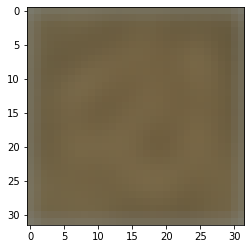

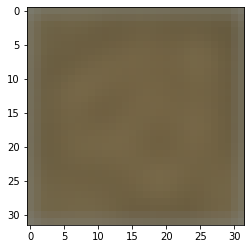

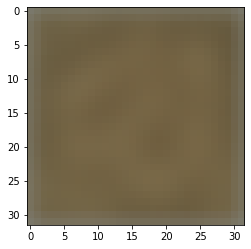

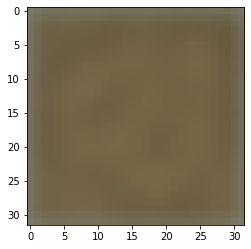

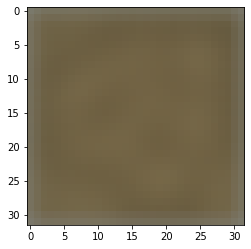

In [44]:
def plot_image_from_path(path):
    img = load_img(path)
    x = img_to_array(img)
    x = np.round(x).astype(np.uint8)
    for i in range(5):
        plt.figure()
        left = 32 * i
        right = 32 * (i+1)
        plt.imshow(x[:,left:right,:])
    
    
plot_image_from_path('data/wgan_images/epoch_210.png')

This was pretty brutal. We trained the WGAN 5 different times totalling an amount approximately 30 hours. These were the best results we had as we tried using different clipping values ranging from [0.01 to 0.05]. We found that using a value of 0.02 allowed the model to create something that wasn't completely black. With these images, we can see an outline of a circular object in the middle. As a result, we would like to hope that if we had trained this model longer, we would have better results. 

## WGAN-GP

<em>[<strong>15 points</strong>] Implement ANOTHER item in the list in the GAN training and generate samples of CIFAR images (only frogs if you like).  Subjectively, did this improve the generated results? Did training time increase or decrease and by how much? Explain.</em>

Again, this implementation of the WGAN-GP has been inspired by following the examples provided by the corresponding GitHub repositories:

https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan/wgan.py & https://github.com/keras-team/keras-contrib/blob/master/examples/improved_wgan.py

These examples provided a significant amount of logic and help in building the following model.

Reusing the WGAN_Base class seen above, we are now going to create the WGAN_GP model.

In [8]:
class WGAN_GP(WGAN_Base):
    def __init__(self, img_height=32, img_width=32, img_channels=3):
        super().__init__(img_height, img_width, img_channels)
        """
        Initializer for the WGAN Class
        """
        # Following parameters and optimizer set as recommended in paper
        self.clip_value = 0.01
        self.optimizer = Adam(0.0001, beta_1=0.5, beta_2=0.9)
        self.training_ratio = 5 # number of discriminator updates per generator update
        self.gradient_penalty_weight = 10
        
    def load_models(self, generator_model_path, discriminator_model_path):
        """
        Loads a dataset of images and formats it to the [-1 to 1] output range of the WGAN;
        Images are also normalized
        """
        custom_objects = {'wasserstein_loss': self.wasserstein_loss,
                          'RandomWeightedAverage': self.RandomWeightedAverage,
                          'gradient_penalty': self.gradient_penalty_loss
                          }
        
        self.generator_model = load_model(generator_model_path, 
                                          custom_objects=custom_objects)
        self.discriminator_model = load_model(discriminator_model_path, 
                                              custom_objects=custom_objects)
        
    class RandomWeightedAverage(_Merge):
        """
        Takes a randomly-weighted average of two tensors. In geometric terms, this
        outputs a random point on the line between each pair of input points.
        Inheriting from _Merge is a little messy but it was the quickest solution I could
        think of. Improvements appreciated.
        """

        def _merge_function(self, inputs):
            weights = K.random_uniform((32, 1, 1, 1))
            return (weights * inputs[0]) + ((1 - weights) * inputs[1])
        
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples,
                              gradient_penalty_weight):
        """
        Calculates the gradient penalty loss for a batch of "averaged" samples.
        In Improved WGANs, the 1-Lipschitz constraint is enforced by adding a term to the
        loss function that penalizes the network if the gradient norm moves away from 1.
        However, it is impossible to evaluate this function at all points in the input
        space. The compromise used in the paper is to choose random points on the lines
        between real and generated samples, and check the gradients at these points. Note
        that it is the gradient w.r.t. the input averaged samples, not the weights of the
        discriminator, that we're penalizing!
        In order to evaluate the gradients, we must first run samples through the generator
        and evaluate the loss. Then we get the gradients of the discriminator w.r.t. the
        input averaged samples. The l2 norm and penalty can then be calculated for this
        gradient.
        Note that this loss function requires the original averaged samples as input, but
        Keras only supports passing y_true and y_pred to loss functions. To get around this,
        we make a partial() of the function with the averaged_samples argument, and use that
        for model training.
        """
        # first get the gradients:
        #   assuming: - that y_pred has dimensions (batch_size, 1)
        #             - averaged_samples has dimensions (batch_size, nbr_features)
        # gradients afterwards has dimension (batch_size, nbr_features), basically
        # a list of nbr_features-dimensional gradient vectors
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = gradient_penalty_weight * K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)
    
    
    def train(self, epochs, batch_size=32, sample_interval=50):
        """
        Trains the GAN given a number of epochs and batch size; at the end of every 
        sample interval, the model outputs generated tiled images
        """        
        # The generator_model is used when we want to train the generator layers.
        # As such, we ensure that the discriminator layers are not trainable.
        # Note that once we compile this model, updating .trainable will have no effect within
        # it. As such, it won't cause problems if we later set discriminator.trainable = True
        # for the discriminator_model, as long as we compile the generator_model first.
        for layer in self.discriminator.layers:
            layer.trainable = False
        self.discriminator.trainable = False
        generator_input = Input(shape=(100,))
        generator_layers = self.generator(generator_input)
        discriminator_layers_for_generator = self.discriminator(generator_layers)
        self.generator_model = Model(inputs=[generator_input],
                                outputs=[discriminator_layers_for_generator])
        # We use the Adam paramaters from Gulrajani et al.
        self.generator_model.compile(optimizer=self.optimizer,
                                loss=self.wasserstein_loss)

        # Now that the generator_model is compiled, we can make the discriminator
        # layers trainable.
        for layer in self.discriminator.layers:
            layer.trainable = True
        for layer in self.generator.layers:
            layer.trainable = False
        self.discriminator.trainable = True
        self.generator.trainable = False

        # The discriminator_model is more complex. It takes both real image samples and random
        # noise seeds as input. The noise seed is run through the generator model to get
        # generated images. Both real and generated images are then run through the
        # discriminator. Although we could concatenate the real and generated images into a
        # single tensor, we don't (see model compilation for why).
        real_samples = Input(shape=self.data.shape[1:])
        generator_input_for_discriminator = Input(shape=(100,))
        generated_samples_for_discriminator = self.generator(generator_input_for_discriminator)
        discriminator_output_from_generator = self.discriminator(generated_samples_for_discriminator)
        discriminator_output_from_real_samples = self.discriminator(real_samples)
        
        # We also need to generate weighted-averages of real and generated samples,
        # to use for the gradient norm penalty.
        averaged_samples = self.RandomWeightedAverage()([real_samples, 
                                                         generated_samples_for_discriminator])

        # We then run these samples through the discriminator as well. Note that we never
        # really use the discriminator output for these samples - we're only running them to
        # get the gradient norm for the gradient penalty loss.
        averaged_samples_out = self.discriminator(averaged_samples)

        # The gradient penalty loss function requires the input averaged samples to get
        # gradients. However, Keras loss functions can only have two arguments, y_true and
        # y_pred. We get around this by making a partial() of the function with the averaged
        # samples here.
        partial_gp_loss = partial(self.gradient_penalty_loss,
                                  averaged_samples=averaged_samples,
                                  gradient_penalty_weight=self.gradient_penalty_weight)
        # Functions need names or Keras will throw an error
        partial_gp_loss.__name__ = 'gradient_penalty'

        # Keras requires that inputs and outputs have the same number of samples. This is why
        # we didn't concatenate the real samples and generated samples before passing them to
        # the discriminator: If we had, it would create an output with 2 * batch_size samples,
        # while the output of the "averaged" samples for gradient penalty
        # would have only batch_size samples.

        # If we don't concatenate the real and generated samples, however, we get three
        # outputs: One of the generated samples, one of the real samples, and one of the
        # averaged samples, all of size batch_size. This works neatly!
        self.discriminator_model = Model(inputs=[real_samples,
                                                 generator_input_for_discriminator],
                                         outputs=[discriminator_output_from_real_samples,
                                                  discriminator_output_from_generator, 
                                                  averaged_samples_out])
        # We use the Adam paramaters from Gulrajani et al. We use the Wasserstein loss for both
        # the real and generated samples, and the gradient penalty loss for the averaged samples
        self.discriminator_model.compile(optimizer=self.optimizer,
                                         loss=[self.wasserstein_loss,
                                               self.wasserstein_loss,
                                               partial_gp_loss])
        # We make three label vectors for training. positive_y is the label vector for real
        # samples, with value 1. negative_y is the label vector for generated samples, with
        # value -1. The dummy_y vector is passed to the gradient_penalty loss function and
        # is not used.
        positive_y = np.ones((batch_size, 1), dtype=np.float32)
        negative_y = -positive_y
        dummy_y = np.zeros((batch_size, 1), dtype=np.float32)

        for epoch in range(epochs):
            np.random.shuffle(self.data)
            print("Epoch: ", epoch)
            print("Number of batches: ", int(self.data.shape[0] // batch_size))
            discriminator_loss = []
            generator_loss = []
            minibatches_size = batch_size * self.training_ratio
            for i in range(int(self.data.shape[0] // (batch_size * self.training_ratio))):
                discriminator_minibatches = self.data[i * minibatches_size:
                                                    (i + 1) * minibatches_size]
                for j in range(self.training_ratio):
                    image_batch = discriminator_minibatches[j * batch_size:
                                                            (j + 1) * batch_size]
                    noise = np.random.rand(batch_size, 100).astype(np.float32)
                    
                    # train discriminator on the real and fake images
                    discriminator_loss.append(self.discriminator_model.train_on_batch(
                        [image_batch, noise],
                        [positive_y, negative_y, dummy_y]))
                    
                # train gan on real data
                generator_loss.append(self.generator_model.train_on_batch(np.random.rand(batch_size, 100),
                                                                          positive_y))

            # If at save interval => save generated image samples
            if epoch % self.sample_interval == 0: 
                self.generate_images(epoch=epoch, num_of_stacked_images=10, isWriting=True)
            

Done. Let's train the model.

In [17]:
wgan_gp = WGAN_GP()
wgan_gp.load_cifar10_frog_data()
wgan_gp.train(epochs=4000)

Epoch:  0
Number of batches:  187
Epoch:  1
Number of batches:  187
Epoch:  2
Number of batches:  187
Epoch:  3
Number of batches:  187
Epoch:  4
Number of batches:  187
Epoch:  5
Number of batches:  187
Epoch:  6
Number of batches:  187
Epoch:  7
Number of batches:  187
Epoch:  8
Number of batches:  187
Epoch:  9
Number of batches:  187
Epoch:  10
Number of batches:  187
Epoch:  11
Number of batches:  187
Epoch:  12
Number of batches:  187
Epoch:  13
Number of batches:  187
Epoch:  14
Number of batches:  187
Epoch:  15
Number of batches:  187
Epoch:  16
Number of batches:  187
Epoch:  17
Number of batches:  187
Epoch:  18
Number of batches:  187
Epoch:  19
Number of batches:  187
Epoch:  20
Number of batches:  187
Epoch:  21
Number of batches:  187
Epoch:  22
Number of batches:  187
Epoch:  23
Number of batches:  187
Epoch:  24
Number of batches:  187
Epoch:  25
Number of batches:  187
Epoch:  26
Number of batches:  187
Epoch:  27
Number of batches:  187
Epoch:  28
Number of batches: 

KeyboardInterrupt: 

Again, because we ran out of time, we had to cut the training short and view the results early. We ran this model for a total of 600 epochs totalling an amount of 30 hours. Let's see some of the results.

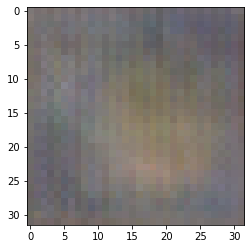

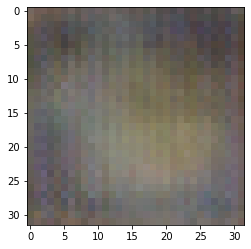

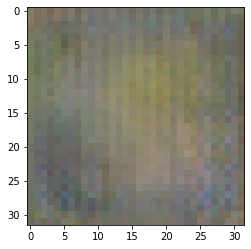

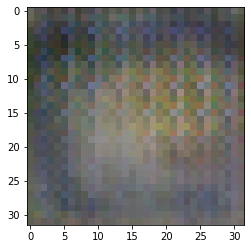

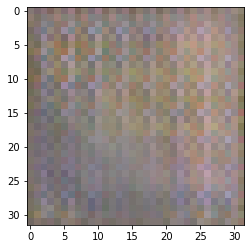

In [45]:
plot_image_from_path('data/wgan_gp_images/epoch_600.png')

These are certainly better than the results of the WGAN, but again the model doesn't really appear to have converged. We certainly would have liked to train the model longer. Interestingly enough, the WGAN-GP seemed to have learned the shape of a frog relatively early on, but then forgot the shape to learn the color of a frog. This can be show viewing the images below.

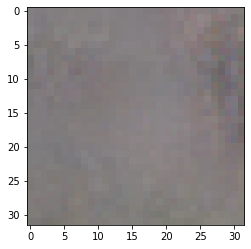

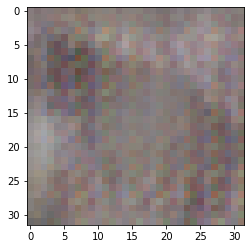

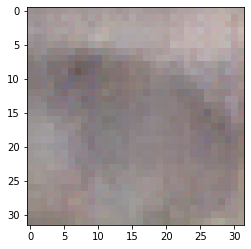

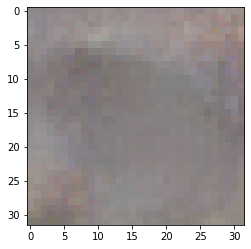

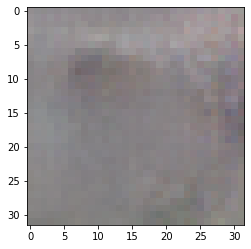

In [46]:
plot_image_from_path('data/wgan_gp_images/epoch_120.png')

Now yes, this is definitely an image where you have to squint to see the frog. Even so, it's interesting to see how while the diversity of the images is miniscule, it still definitely started to grasp a frog's shape. These images were taken from the 120th epoch, again showing how the model forgot the shape of a frog to learn the color of one.

<em>[<strong>10 points</strong>] Exceptional work: Implement ANOTHER item in the list in the GAN training and generate samples of CIFAR images (only frogs if you like). Subjectively, did this improve the generated results? Did training time increase or decrease and by how much? Explain. </em>

### Feature Matching

We attempted to implement feature matching within the GAN. Feature matching  essentially  penalizes the mean absolute error between the average value of some set of features on the training data and the average values of that set of features on the generated samples.

In [44]:
# here we create a discriminator that is identical to Chollet's except it has 2 outputs
# the first is the loss which is the same as Chollet's
# the second is the set of features that are then used within the feature matching
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)
# here is where the features get grabbed for output
x_out1 = x

# One dropout layer - important trick!
x = layers.Dropout(0.4)(x)

# Classification layer
x = layers.Dense(1, activation='sigmoid')(x)

# create the model with 2 outputs and view the summary
fm_discriminator = keras.models.Model(discriminator_input, [x, x_out1])
fm_discriminator.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_34 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_35 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 6, 6, 128)         0  

In [69]:
# same values for images as Chollet's
latent_dim = 32
height = 32
width = 32
channels = 3

# create both real and noise inputs
real_input = keras.Input(shape=(height, width, channels))
noise_input = keras.Input(shape=(latent_dim,))

# generate a fake image with the generator
fake_image = generator(noise_input)

# get the loss and features from the discriminator for both the real and the fake inputs
discriminator_real_out, discriminator_real_feats = fm_discriminator(real_input)
discriminator_fake_out, discriminator_fake_feats = fm_discriminator(fake_image)

# take the mean of both sets of features
discriminator_real_average_feats = K.mean(discriminator_real_feats, axis=0)
discriminator_fake_average_feats = K.mean(discriminator_fake_feats, axis=0)

# define the loss as the mean of the square of the difference between the feature averages
def fm_loss(self, y_true = 0, y_pred = 0):
    return K.mean(K.square(discriminator_real_average_feats  - discriminator_fake_average_feats))

# create new generator that takes real and fake inputs and losses
generator_train = keras.models.Model([real_input, noise_input], [discriminator_real_out, discriminator_fake_out])

# set discriminator traninable to false
fm_discriminator.trainable=False

# compile discriminator with just binary crossentropy
fm_discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

# compile  the generator with the feature matching loss and binary crossentropy
generator_train.compile(optimizer = gan_optimizer, loss=[fm_loss, 'binary_crossentropy'])
generator_train.summary()

Model: "model_22"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           (None, 32)           0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 32, 32, 3)    6264579     input_31[0][0]                   
__________________________________________________________________________________________________
model_20 (Model)                [(None, 1), (None, 5 790913      input_30[0][0]                   
                                                                 model_1[15][0]            

Up until this point, everything is set up and working as expected. However, when it came to actual training, we unfortunately got lost and could not make it work. Below is a modified train function that (unsuccessfully) uses the new generator and discriminator. We could not figure out exactly what to pass into the generator in the `generator_train.predict()`, but hope that our efforts could potentially merit some partial extra credit. 

In [87]:
def train2(gan, discriminator, iterations = 10000, batch_size = 20, name = 'gan', save_dir = 'data/'):
    # Start training loop
    start = 0
    for step in range(iterations):
        real_input = np.random.normal(size=(batch_size, height, width, channels))
        # Sample random points in the latent space
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # error is with this prediction
        # Decode them to fake images
        generated_images = generator_train.predict([real_input, random_latent_vectors])

        # Combine them with real images
        stop = start + batch_size
        real_images = x_train[start: stop]
        combined_images = np.concatenate([generated_images, real_images])

        # Assemble labels discriminating real from fake images
        labels = np.concatenate([np.ones((batch_size, 1)),
                                 np.zeros((batch_size, 1))])

        # Add random noise to the labels - important trick!
        labels += 0.05 * np.random.random(labels.shape)

        # numpy array with same shape of feature output of discriminator 
        dummy = np.zeros((2*batch_size,512))
        
        # Train the discriminator
        d_loss = discriminator.train_on_batch(combined_images, [labels, dummy])

        # sample random points in the latent space
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # Assemble labels that say "all real images"
        misleading_targets = np.zeros((batch_size, 1))
        
        # Train the generator (via the gan model, where the discriminator weights are frozen)
        a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

        start += batch_size
        if start > len(x_train) - batch_size:
            start = 0

        # Occasionally save / plot
        if step % 100 == 0: 
            # Save model weights
            gan.save_weights(f'{name}.h5')

            # Print metrics
            print('discriminator loss at step %s: %s' % (step, d_loss))
            print('adversarial loss at step %s: %s' % (step, a_loss))

            # Save one generated image
            img = image.array_to_img(generated_images[0] * 255., scale=False)
            img.save(os.path.join(save_dir, 'generated_frog' + str(step) + '.png'))

            # Save one real image, for comparison
            img = image.array_to_img(real_images[0] * 255., scale=False)
            img.save(os.path.join(save_dir, 'real_frog' + str(step) + '.png'))

In [88]:
train2(gan, fm_discriminator, iterations = 10, name = 'feature_matching', save_dir = 'data/feature_matching/')

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 4 dimension(s)

Bummer. Let's move onto another one of our attempts.

### Historical Averaging

Before diving into feature matching, we also took a brief stab at historical averaging. Unfortunately, we were unable to get this working either, but figured we should still show our attempt with hopes of some possible partial extra credit. 

In [ ]:
# class found here: https://stackoverflow.com/questions/57116349/keras-historical-averaging-custom-loss-function
class HistoricalAvgLoss(object):
    def __init__(self, model):
        # create tensors (initialized to zero) to hold the previous value of the weights
        self.model = model
        self.prev_weights = []
        # iterate over all model.layers
        for w in model.weights:
          self.prev_weights.append(K.variable(np.zeros(w.shape)))

    def loss(self, y_true, y_pred):
        err = keras.losses.mean_squared_error(y_true, y_pred)
        werr = [K.mean(K.abs(c - p)) for c, p in zip(self.model.weights, self.prev_weights)]
        self.prev_weights = K.in_train_phase(
            [K.update(p, c) for c, p in zip(self.model.weights, self.prev_weights)], self.prev_weights
        )
        return K.in_train_phase(err + K.sum(werr), err)

In [ ]:
discriminator.trainable = True

ha_loss_obj = HistoricalAvgLoss(discriminator)

discriminator.compile(optimizer=discriminator_optimizer, loss=ha_loss_obj.loss)

In [ ]:
%%time
train(gan, discriminator, iterations = 100, name = 'historical_averaging', save_dir = 'data/historical_averaging/')